In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro, bartlett
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import qsturng


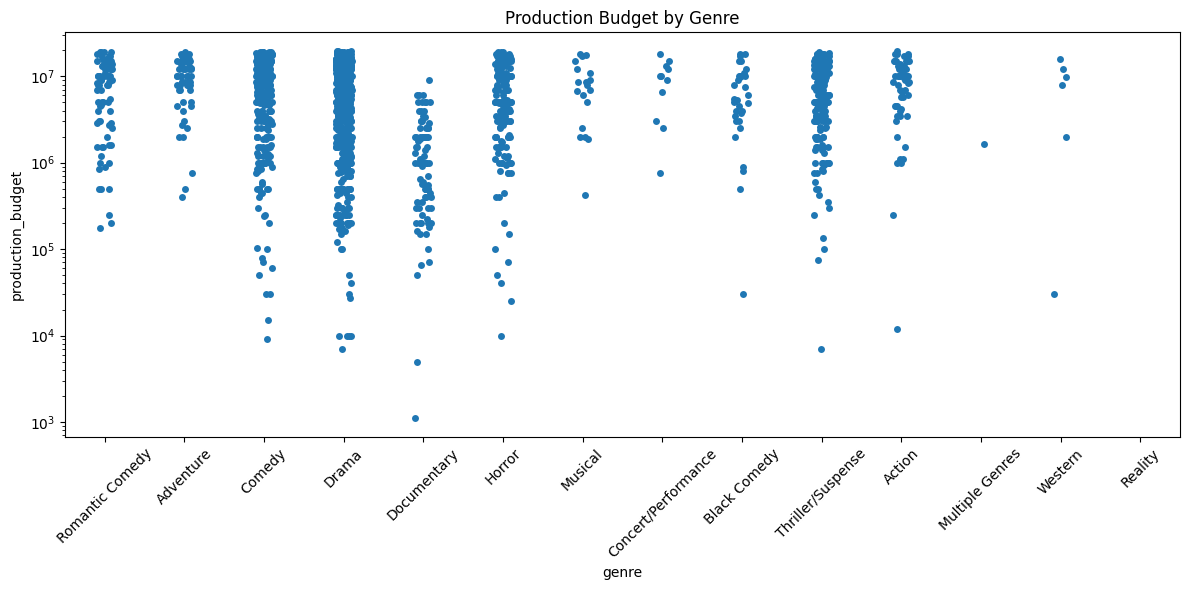

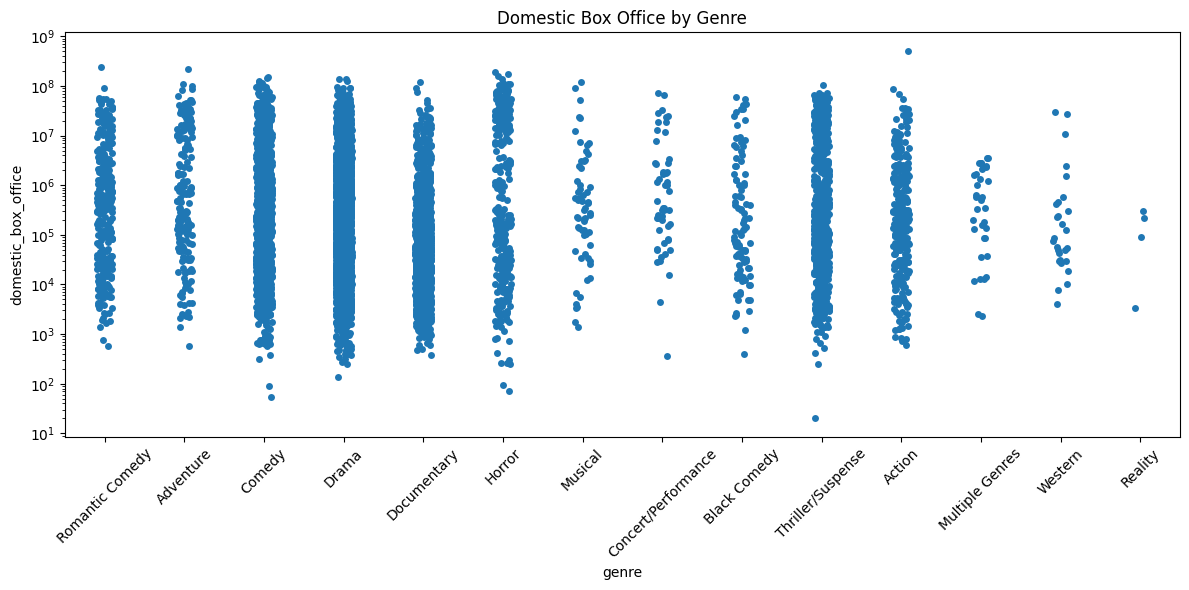

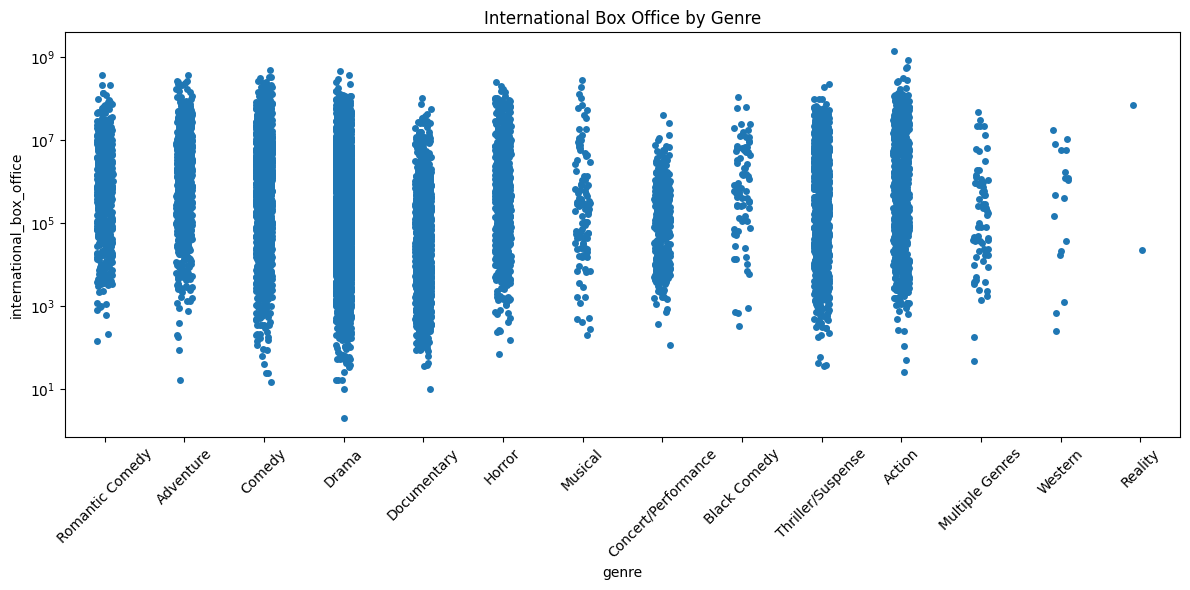

In [10]:
# Load data
df = pd.read_csv('movie_summary.csv')

# Filter by production year and budget
filtered_df = df[
    (df['production_year'] > 2000) & 
    (df['production_budget'] < 20000000) & 
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
]

# Strip plot (with jitter to separate overlapping points)
plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='production_budget', jitter=True)
plt.yscale('log')
plt.title("Production Budget by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='domestic_box_office', jitter=True)
plt.yscale('log')
plt.title("Domestic Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='international_box_office', jitter=True)
plt.yscale('log')
plt.title("International Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

$$
\begin{aligned}
H_0: &\text{The box office of the movies of different genres are eqivalent.} \\
H_1: &\text{The box office of the movies of at least one genre is different from others.}
\end{aligned}
$$

In [3]:
# ---------------------------
# Shapiro-Wilk Normality Test (per genre group)
# ---------------------------
print("=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===")
genre_groups = filtered_df.groupby('genre')['domestic_box_office']

for genre, values in genre_groups:
    if len(values) >= 3:  # Shapiro-Wilk requires at least 3 values
        stat, p = shapiro(values)
        print(f"Genre: {genre:<20} | W = {stat:.4f} | p = {p:.4f}")

# ---------------------------
# Bartlett's Test (Equal variances across genres)
# ---------------------------
# Collect lists of values per genre
grouped_values = [  group['domestic_box_office'].values 
                    for name, group in filtered_df.groupby('genre') 
                    if len(group) >= 3  ]

print("\n=== Bartlett's Test (Domestic Box Office across Genres) ===")
bartlett_stat, bartlett_p = bartlett(*grouped_values)
print(f"Bartlett's Test: stat = {bartlett_stat:.4f} | p = {bartlett_p:.4f}\n")

=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===
Genre: Action               | W = 0.0493 | p = 0.0000
Genre: Adventure            | W = 0.1652 | p = 0.0000
Genre: Black Comedy         | W = 0.3866 | p = 0.0000
Genre: Comedy               | W = 0.2425 | p = 0.0000
Genre: Concert/Performance  | W = 0.1249 | p = 0.0000
Genre: Documentary          | W = 0.1125 | p = 0.0000
Genre: Drama                | W = 0.2043 | p = 0.0000
Genre: Horror               | W = 0.3536 | p = 0.0000
Genre: Multiple Genres      | W = 0.4718 | p = 0.0000
Genre: Musical              | W = 0.2001 | p = 0.0000
Genre: Reality              | W = 0.8887 | p = 0.3508
Genre: Romantic Comedy      | W = 0.2091 | p = 0.0000
Genre: Thriller/Suspense    | W = 0.2927 | p = 0.0000
Genre: Western              | W = 0.3008 | p = 0.0000

=== Bartlett's Test (Domestic Box Office across Genres) ===
Bartlett's Test: stat = 6996.2640 | p = 0.0000



c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5822.
  res = hypotest_fun_out(*samples, **kwds)


In [4]:
# Welch's ANOVA for domestic box office
print("=== Welch's ANOVA: Domestic Box Office ===")
welch_domestic = pg.welch_anova(dv='domestic_box_office', between='genre', data=filtered_df)
print(welch_domestic)

print("\n=== Welch's ANOVA: International Box Office ===")
welch_international = pg.welch_anova(dv='international_box_office', between='genre', data=filtered_df)
print(welch_international)

=== Welch's ANOVA: Domestic Box Office ===
  Source  ddof1       ddof2          F         p-unc       np2
0  genre     13  400.636598  30.513549  5.156972e-52  0.014611

=== Welch's ANOVA: International Box Office ===
  Source  ddof1       ddof2          F         p-unc       np2
0  genre     13  213.184455  50.568593  9.285180e-58  0.022648



=== Tukey HSD: Domestic Box Office ===
Q critical value = 4.743618
Tukey Omega = 6307951.989673
                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
       group1              group2          meandiff   p-adj      lower          upper     reject
------------------------------------------------------------------------------------------------
             Action           Adventure     424001.47 0.9997  -1086320.1165  1934323.0565  False
             Action        Black Comedy  2047493.9035 0.6255  -1066088.3667  5161076.1737  False
             Action              Comedy   963696.0346  0.364   -297028.8838  2224420.9529  False
             Action Concert/Performance  -705983.3544 0.9937  -2601361.8707  1189395.1619  False
             Action         Documentary  -893000.8767 0.4978  -2153501.0494   367499.2959  False
             Action               Drama   -64673.6523    1.0  -1240869.5137   1111522.209  False
             Action           

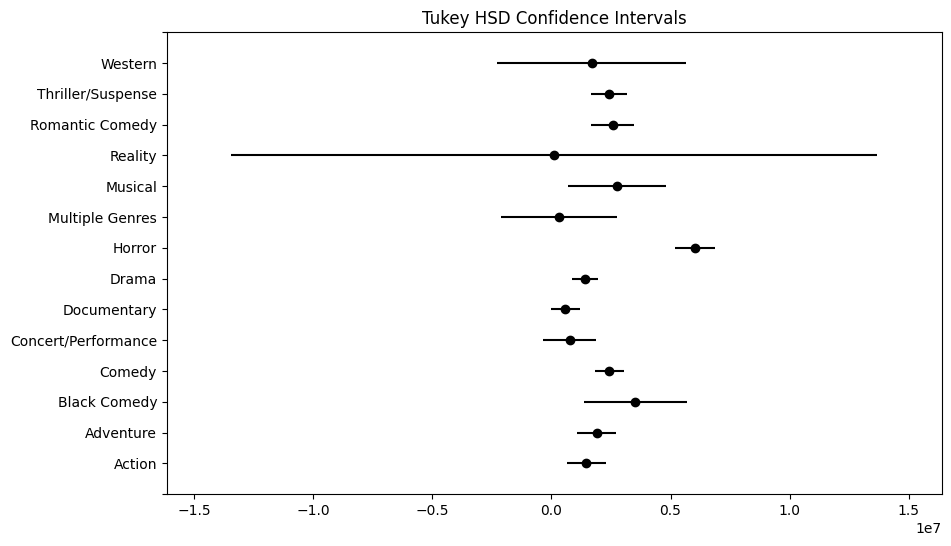


=== Tukey HSD: International Box Office ===


c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Q critical value = 4.743618
Tukey Omega = 14354597.465823
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
       group1              group2          meandiff    p-adj      lower          upper      reject
--------------------------------------------------------------------------------------------------
             Action           Adventure  -6841630.3158    0.0 -10278571.2523  -3404689.3794   True
             Action        Black Comedy  -11565921.117    0.0  -18651298.469  -4480543.7649   True
             Action              Comedy  -9820091.4175    0.0 -12689041.3948  -6951141.4402   True
             Action Concert/Performance -14827869.1261    0.0 -19141059.1586 -10514679.0936   True
             Action         Documentary -15032247.0115    0.0 -17900685.5497 -12163808.4733   True
             Action               Drama -12036451.6531    0.0 -14713044.3346  -9359858.9716   True
             Action              Horror  -9097562.2

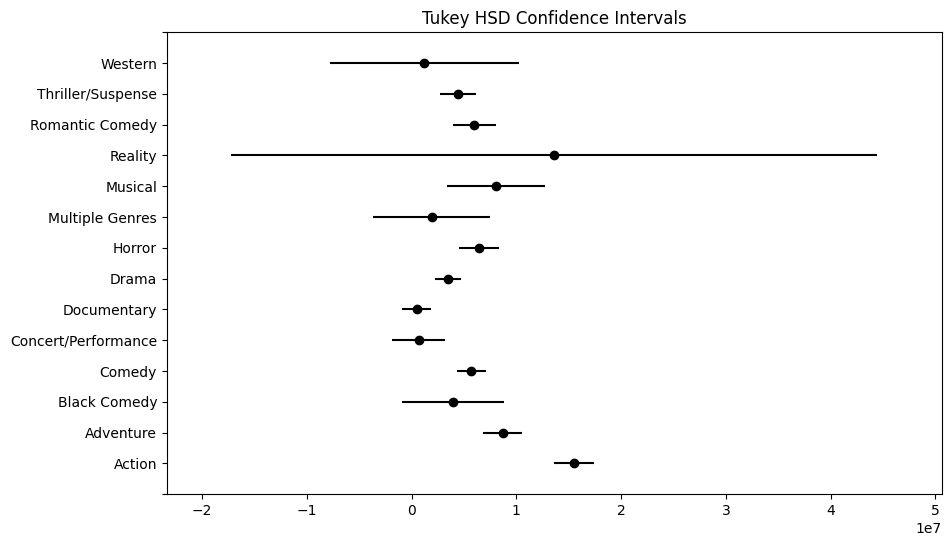

In [5]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k

    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    # Plot overall CI
    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    # Optional: Focused plot on a specific group
    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

# Run Tukey HSD for domestic box office
print("\n=== Tukey HSD: Domestic Box Office ===")
summary_dom, omega_dom = tukey_hsd(filtered_df, 'domestic_box_office', 'genre')

# Run Tukey HSD for international box office
print("\n=== Tukey HSD: International Box Office ===")
summary_intl, omega_intl = tukey_hsd(filtered_df, 'international_box_office', 'genre')